# Fake Celebrity Images Using Generative adversarial network (GAN)

### 1. Loading packages & setting up GPU

In [1]:
# GPU usage visualization
!nvidia-smi

Tue Jan  9 09:24:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# setting gpu by number
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # setting gpu number

# 2. Loading Packages


In [3]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio #### install with "pip install imageio"
from IPython.display import HTML
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [4]:
# Create folders
if not os.path.exists('./checkpoint'):
    os.mkdir('./checkpoint')

if not os.path.exists('./dataset'):
    os.mkdir('./dataset')

if not os.path.exists('./img'):
    os.mkdir('./img')

if not os.path.exists('./img/real'):
    os.mkdir('./img/real')

if not os.path.exists('./img/fake'):
    os.mkdir('./img/fake')

### 3. Defining visualization & image saving code

In [5]:
# visualize the first image from the torch tensor
def vis_image(image):
    plt.imshow(image[0].detach().cpu().numpy(),cmap='gray')
    plt.show()

In [6]:
def save_gif(training_progress_images, images):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('./img/training_progress.gif', training_progress_images)
    return training_progress_images

In [7]:
# visualize gif file
def vis_gif(training_progress_images):
    fig = plt.figure()

    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

    html = ani.to_html5_video()
    HTML(html)

In [8]:
# visualize gif file
def plot_gif(training_progress_images, plot_length=10):
    plt.close()
    fig = plt.figure()

    total_len = len(training_progress_images)
    for i in range(plot_length):
        im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
        plt.show()

In [9]:
def save_image_list(dataset, real):
    if real:
        base_path = './img/real'
    else:
        base_path = './img/fake'

    dataset_path = []

    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)

    return base_path

In [10]:
train_ds = ImageFolder(root="/kaggle/input/celeb-a-practice/Img/img_align_celeba", 
                      transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                         (0.5, 0.5, 0.5),
                                         (0.5, 0.5, 0.5))
                                          ]))


In [11]:
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
nc = 3 # number of channels, RGB
nz = 128 # input noise dimension
ngf = 64 # number of generator filters
ndf = 64 #number of discriminator filters

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [15]:
netG = Generator().cuda()
netD = Discriminator().cuda()
netG.load_state_dict(torch.load(f="/kaggle/input/model-a-cele-a/netG_epoch_99.pth"))
netD.load_state_dict(torch.load(f="/kaggle/input/model-a-cele-a/netD_epoch_99.pth"))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

In [16]:
next(iter(dataloader))[0].shape

torch.Size([32, 3, 64, 64])

In [17]:
noise = torch.randn(32, 128,1,1).cuda()

In [18]:
fixed_noise = torch.randn(32, 128,1,1).cuda()

criterion = nn.BCELoss()

n_epoch = 100
training_progress_images_list = []
for epoch in range(n_epoch):
    for i, (data, _) in enumerate(dataloader):
        ####################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        ###################################################
        # train with real
        netD.zero_grad()
        data = data.cuda()
        batch_size = data.size(0)

        label = torch.ones((batch_size, )).cuda() # real label
        output = netD(data)
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, 128,1,1).cuda()
        fake = netG(noise)
        label = torch.zeros((batch_size, )).cuda() # fake label
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        # Loss backward
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        ########################################
        # (2) Update G network: maximize log(D(G(z))) #
        ########################################
        netG.zero_grad()
        label = torch.ones((batch_size, )).cuda() # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        errG.backward()
        optimizerG.step()
    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f'
              % (epoch, n_epoch, errD.item(), errG.item()))

    #save the output
    fake = netG(fixed_noise)
    training_progress_images_list = save_gif(training_progress_images_list, fake)  # Save fake image while training!

    # Check pointing for every epoch
    torch.save(netG.state_dict(), './checkpoint/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), './checkpoint/netD_epoch_%d.pth' % (epoch))

[0/100] Loss_D: 2.1301 Loss_G: 33.8926
[1/100] Loss_D: 0.0022 Loss_G: 20.4153
[2/100] Loss_D: 0.4575 Loss_G: 16.2839
[3/100] Loss_D: 0.0076 Loss_G: 9.5221
[4/100] Loss_D: 0.3339 Loss_G: 45.8373
[5/100] Loss_D: 0.4871 Loss_G: 41.4202
[6/100] Loss_D: 0.0000 Loss_G: 17.3948
[7/100] Loss_D: 0.0273 Loss_G: 31.0599
[8/100] Loss_D: 0.0018 Loss_G: 16.9975
[9/100] Loss_D: 0.0000 Loss_G: 34.8719
[10/100] Loss_D: 0.0015 Loss_G: 12.4472
[11/100] Loss_D: 0.0019 Loss_G: 22.2224
[12/100] Loss_D: 0.7507 Loss_G: 11.8550
[13/100] Loss_D: 0.0001 Loss_G: 11.7062
[14/100] Loss_D: 0.0015 Loss_G: 12.4694
[15/100] Loss_D: 1.8409 Loss_G: 18.3362
[16/100] Loss_D: 0.0028 Loss_G: 17.5761
[17/100] Loss_D: 0.0066 Loss_G: 12.1188
[18/100] Loss_D: 0.0151 Loss_G: 17.2068
[19/100] Loss_D: 0.9617 Loss_G: 12.3546
[20/100] Loss_D: 0.2739 Loss_G: 16.3962
[21/100] Loss_D: 0.0027 Loss_G: 28.6007
[22/100] Loss_D: 0.0008 Loss_G: 14.3040
[23/100] Loss_D: 0.2125 Loss_G: 18.3729
[24/100] Loss_D: 0.0374 Loss_G: 16.3151
[25/100] Lo

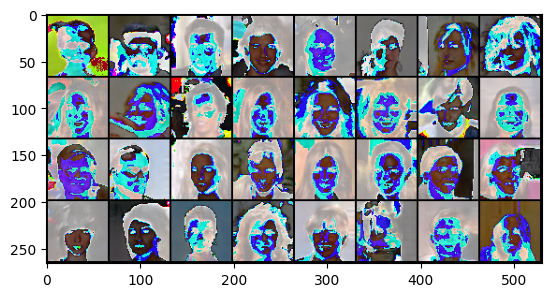

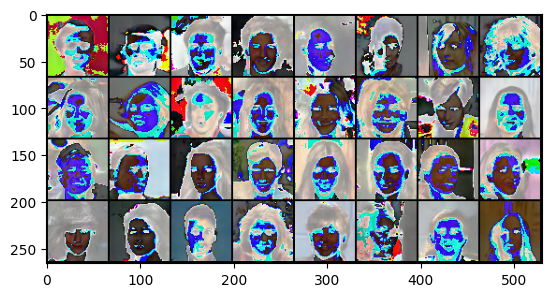

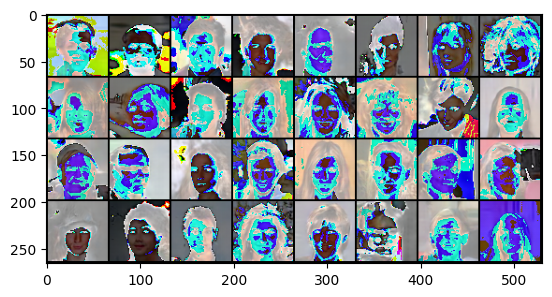

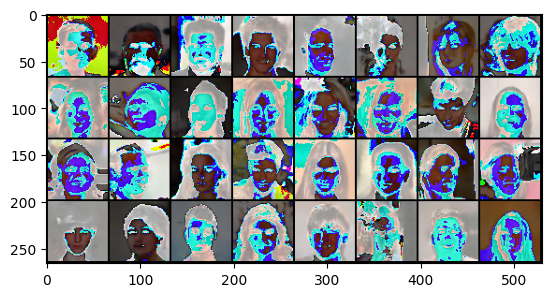

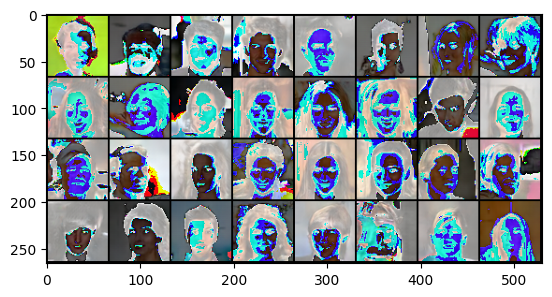

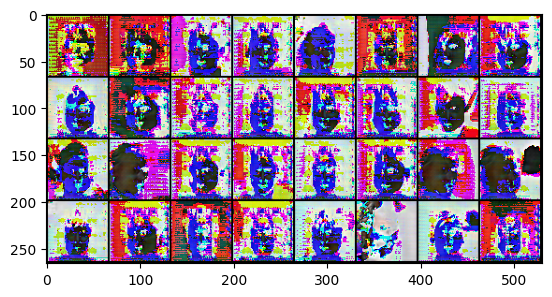

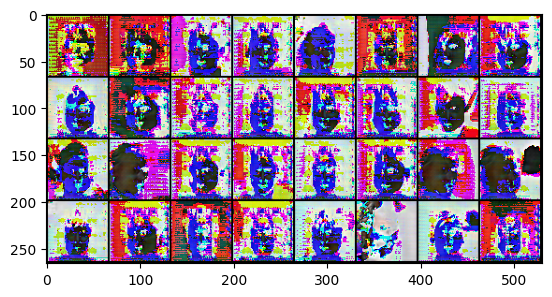

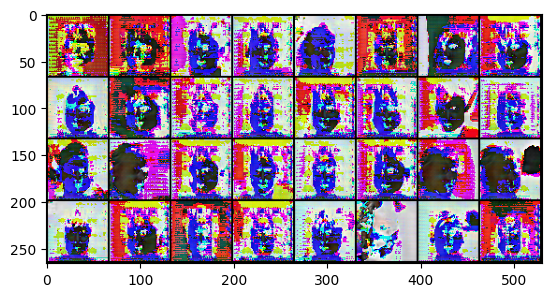

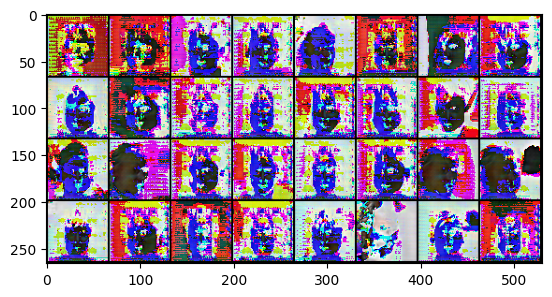

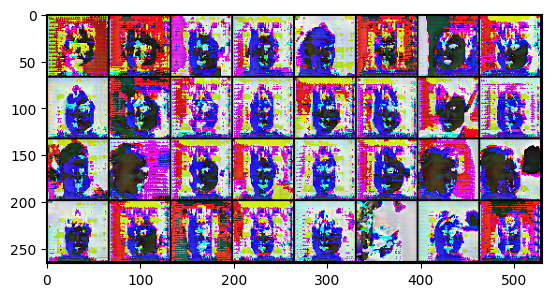

In [19]:
plot_gif(training_progress_images_list)

## Reference

PyTorch official DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html \
github 1: https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py \
github 2: https://github.com/mseitzer/pytorch-fid \
FID score: https://github.com/mseitzer/pytorch-fid \
Inception score: https://github.com/sbarratt/inception-score-pytorch